In [1]:
import os
import shutil
import tempfile
import time
from typing import Any, Dict, List, Tuple, Union

import argparse
import joblib
from joblib import Parallel, delayed
import numpy as np
import pickle as pkl
from termcolor import cprint
import torch
import torch.nn as nn
import torch.nn.functional as F

from logger import Logger
import utils.baseline_config as config
import utils.baseline_utils as baseline_utils
from utils.lstm_utils import ModelUtils, LSTMDataset

use_cuda = torch.cuda.is_available()
if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
global_step = 0
best_loss = float("inf")
np.random.seed(100)

ROLLOUT_LENS = [1, 10, 30]

In [268]:
from prob_lstm_train_test import *

argString = '--test_features features/val.pkl --train_features features/train.pkl  --val_features features/val.pkl --normalize --obs_len 20 --pred_len 30 --model_path model/lstm_prob.pkl --traj_save_path traj/lstm_prob.pkl'
args = parser.parse_args(shlex.split(argString))

In [21]:
data_dict = baseline_utils.get_data(args, 'none')

Loading Test data ...
Normalizing ...
Creating relative distances...
Test Size: 39472
Loading Train data ...
Normalizing ...
Creating relative distances...
Train Size: 205942
Loading Val data ...
Normalizing ...
Creating relative distances...
Val Size: 39472


In [22]:
data_dict['val_input'].shape

(39472, 20, 2)

In [23]:
with open('features/val.pkl', "rb") as f:
    features_df: pd.DataFrame = pkl.load(f)

In [24]:
features_df.columns

Index(['SEQUENCE', 'FEATURES', 'CANDIDATE_CENTERLINES', 'ORACLE_CENTERLINE',
       'CANDIDATE_NT_DISTANCES'],
      dtype='object')

In [26]:
features_df['SEQUENCE'].size

39472

In [180]:
valids = [i[0] for i in rose_val_df['agent_id'].tolist()]
idxs = []
for i,row in features_df.iterrows():
    if row['FEATURES'][0][1] in valids:
        idxs.append(i)

In [181]:
print(len(valids),len(idxs))

3023 7775


In [174]:
carids = []
for i,row in features_df.iterrows():
    carids.append([row['FEATURES'][0][1]])

In [175]:
carids[:3]

[['00000000-0000-0000-0000-000000032795'],
 ['00000000-0000-0000-0000-000000088947'],
 ['00000000-0000-0000-0000-000000180875']]

In [152]:
for i,row in features_df.iterrows():
    if row['FEATURES'][29][1] =='00000000-0000-0000-0000-000000014164':
        print(i)


51
20
89
26
42
43
25
93


In [162]:
features_df.iloc[[51,20,89,26,42,43,25,93]]['SEQUENCE'].tolist()

[40731, 35547, 3379, 3870, 40908, 1338, 11229, 35954]

In [176]:
features_df['car_id'] = carids

In [140]:
len(ids)

3023

In [139]:
len(idxs)

7775

In [182]:
sub_val_df = features_df.iloc[idxs]

In [222]:
sub_val_df.columns

Index(['SEQUENCE', 'FEATURES', 'CANDIDATE_CENTERLINES', 'ORACLE_CENTERLINE',
       'CANDIDATE_NT_DISTANCES', 'car_id'],
      dtype='object')

In [183]:
sub_val_df

SEQUENCE                                           FEATURES  \
0       7510  [[315968760.48507446, 00000000-0000-0000-0000-...   
4      24776  [[315968818.9360202, 00000000-0000-0000-0000-0...   
14     17115  [[315969043.62272835, 00000000-0000-0000-0000-...   
17     35370  [[315967961.51631737, 00000000-0000-0000-0000-...   
22     11914  [[315973349.87287015, 00000000-0000-0000-0000-...   
..       ...                                                ...   
71     31453  [[315978392.91245306, 00000000-0000-0000-0000-...   
86      2361  [[315992330.627927, 00000000-0000-0000-0000-00...   
87     10977  [[315968855.97119826, 00000000-0000-0000-0000-...   
96      2523  [[315971747.72625375, 00000000-0000-0000-0000-...   
98     22863  [[315973034.21272165, 00000000-0000-0000-0000-...   

                                CANDIDATE_CENTERLINES  \
0   [[[None, None], [None, None], [None, None], [N...   
4   [[[None, None], [None, None], [None, None], [N...   
14  [[[None, None], [None, None], [None, None], [N...   
17  [[[None, None], [None, None], [None, None], [N...   
22  [[[None, None], [None, None], [None, None], [N...   
..                                                ...   
71  [[[None, None], [None, None], [None, None], [N...   
86  [[[None, None], [None, None], [None, None], [N...   
87  [[[None, None], [None, None], [None, None], [N...   
96  [[[None, None], [None, None], [None, None], [N...   
98  [[[None, None], [None, None], [None, None], [N...   

                                    ORACLE_CENTERLINE  \
0   [[2025.0090482828673, 704.5678484877571], [202...   
4   [[1713.2856100839563, 339.0488387220539], [171...   
14  [[1939.226357601292, 535.7488339687698], [1931...   
17  [[1879.0457139598439, 474.20368249202147], [18...   
22  [[1951.8931380767026, 546.4221814647317], [195...   
..                                                ...   
71  [[1714.978497648437, 336.380563524086], [1716....   
86  [[1634.6858347562375, 378.77559478301555], [16...   
87  [[423.21553415752714, 961.3220839302521], [423...   
96  [[2169.0931798012325, 720.0], [2165.2080007041...   
98  [[602.1215269762324, 1038.3553594155237], [605...   

                               CANDIDATE_NT_DISTANCES  \
0   [[[None, None], [None, None], [None, None], [N...   
4   [[[None, None], [None, None], [None, None], [N...   
14  [[[None, None], [None, None], [None, None], [N...   
17  [[[None, None], [None, None], [None, None], [N...   
22  [[[None, None], [None, None], [None, None], [N...   
..                                                ...   
71  [[[None, None], [None, None], [None, None], [N...   
86  [[[None, None], [None, None], [None, None], [N...   
87  [[[None, None], [None, None], [None, None], [N...   
96  [[[None, None], [None, None], [None, None], [N...   
98  [[[None, None], [None, None], [None, None], [N...   

                                    car_id  
0   [00000000-0000-0000-0000-000000032795]  
4   [00000000-0000-0000-0000-000000019290]  
14  [00000000-0000-0000-0000-000000003840]  
17  [00000000-0000-0000-0000-000000023604]  
22  [00000000-0000-0000-0000-000000049362]  
..                                     ...  
71  [00000000-0000-0000-0000-000000045133]  
86  [00000000-0000-0000-0000-000000205369]  
87  [00000000-0000-0000-0000-000000013906]  
96  [00000000-0000-0000-0000-000000053374]  
98  [00000000-0000-0000-0000-000000062964]  

[7775 rows x 6 columns]

In [243]:
sub_val_df.iloc[0]['FEATURES'].shape

(50, 11)

In [56]:
with open('traj/lstm_mis_scale100.pkl', "rb") as f:
    forecasted_trajectories: Dict[int, List[np.ndarray]] = pkl.load(f)

In [57]:
forecasted_trajectories

{22474: [array([[ 7.48440918e+02,  1.52839307e+03,  2.09928942e+00,
           7.70127654e-01,  2.94749022e-01],
         [ 7.48219604e+02,  1.52835681e+03,  2.13808322e+00,
           8.59999180e-01,  2.89171845e-01],
         [ 7.47994385e+02,  1.52829968e+03,  2.18791437e+00,
           9.26964641e-01,  2.98433423e-01],
         [ 7.47760620e+02,  1.52823450e+03,  2.19090843e+00,
           9.91092145e-01,  3.06067258e-01],
         [ 7.47521545e+02,  1.52816187e+03,  2.16674042e+00,
           1.04546750e+00,  3.13832790e-01],
         [ 7.47276062e+02,  1.52808203e+03,  2.12923050e+00,
           1.09507537e+00,  3.19310069e-01],
         [ 7.47023193e+02,  1.52799463e+03,  2.08239365e+00,
           1.14110172e+00,  3.21970344e-01],
         [ 7.46761780e+02,  1.52789905e+03,  2.02940917e+00,
           1.18487251e+00,  3.21601629e-01],
         [ 7.46490784e+02,  1.52779468e+03,  1.97259164e+00,
           1.22734010e+00,  3.17997813e-01],
         [ 7.46209412e+02,  1.52768091e

In [38]:
encoder = EncoderRNN(input_size=len(baseline_utils.BASELINE_INPUT_FEATURES['none']))
decoder = DecoderRNN(output_size=5)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=args.lr)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=args.lr)

In [39]:
model_utils = ModelUtils()
model_utils.load_checkpoint('./model/nll_no_delta/LSTM_rollout30.pth.tar',encoder,decoder,encoder_optimizer,decoder_optimizer)

=> loading checkpoint './model/nll_no_delta/LSTM_rollout30.pth.tar'
=> loaded checkpoint ./model/nll_no_delta/LSTM_rollout30.pth.tar (epoch: 211, loss: 2.8540358543395996)


(211, 30, tensor(2.8540, requires_grad=True))

In [ ]:
temp_save_dir = tempfile.mkdtemp()

test_size = data_dict["test_input"].shape[0]
print('test size', test_size)
test_data_subsets = baseline_utils.get_test_data_dict_subset(data_dict, args)

for i in  range(0, test_size, args.joblib_batch_size):
    
    curr_test_dataset = LSTMDataset(test_data_subsets[i], args, "test")
    curr_test_loader = torch.utils.data.DataLoader(
        test_data_subsets[i],
        shuffle=False,
        batch_size=args.test_batch_size,
        collate_fn=model_utils.my_collate_fn,
    )
    infer_helper(args, test_data_subsets[i], i, encoder, decoder,
                                  model_utils, temp_save_dir)

    
traj_save_path = 'traj/lstm_nll_test.pkl'
baseline_utils.merge_saved_traj(temp_save_dir, traj_save_path) #args.traj_save_path
shutil.rmtree(temp_save_dir)
print(f"Forecasted Trajectories saved at {traj_save_path}")

## roselab val dataset

In [69]:
import pickle 
with open('../P-ECCO/results/nll_dyna_local_predictions.pickle','rb') as f:
    prediction_gt_dyna = pickle.load(f)

In [87]:
subsubset = [lookup[k] for k in list(prediction_gt_dyna.keys())[1:]]

In [ ]:
prediction_gt_dyna.keys()

In [106]:
import sys
sys.path.append('../P-ECCO')
from datasets.argoverse_lane_loader import read_pkl_data


In [167]:
val_dataset = read_pkl_data('../argoverse_data/rose/val', batch_size=1, shuffle=False, repeat=False)

In [168]:
rose_val_dicts = []
for sample in val_dataset:
    rose_val_dicts.append(sample)
    '''
    agent_id = sample['agent_id']
    ids.append(agent_id)
    city = sample['city']
    scene = sample['scene_idx']
    scenes.append(scene)
    scene_agaentid[scene[0]] = int(agent_id[0][-12:])
    '''

In [169]:
rose_val_df = pd.DataFrame(rose_val_dicts)

In [210]:
rose_val_df.head()

city                                               lane  \
0  [PIT]  [[[1734.5113525390625, 352.9620056152344], [17...   
1  [MIA]  [[[605.4078369140625, 1247.7041015625], [610.8...   
2  [PIT]  [[[1647.0281982421875, 278.59368896484375], [1...   
3  [PIT]  [[[2165.2080078125, 716.7066040039062], [2161....   
4  [PIT]  [[[1933.9405517578125, 527.3703002929688], [19...   

                                           lane_norm scene_idx  \
0  [[[5.110144138336182, 4.2653632164001465], [5....   [10002]   
1  [[[5.407813549041748, 0.26556169986724854], [5...   [10019]   
2  [[[1.6605260372161865, 2.0836880207061768], [0...   [10028]   
3  [[[-3.885179042816162, -3.293391227722168], [-...    [1003]   
4  [[[-7.316390514373779, -6.115136623382568], [-...   [10069]   

                                 agent_id  \
0  [00000000-0000-0000-0000-000000027906]   
1  [00000000-0000-0000-0000-000000014164]   
2  [00000000-0000-0000-0000-000000019889]   
3  [00000000-0000-0000-0000-000000003414]   
4  [00000000-0000-0000-0000-000000080560]   

                                            car_mask  \
0  [[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...   
1  [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0...   
2  [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...   
3  [[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [0...   
4  [[[1.0], [1.0], [1.0], [1.0], [0.0], [0.0], [0...   

                                                p_in  \
0  [[[[1730.4564209   353.33584595], [1731.272094...   
1  [[[[ 578.98168945 1307.13500977], [ 579.000976...   
2  [[[[1666.3861084   292.13204956], [1666.902343...   
3  [[[[2118.6262207   677.63000488], [2117.571533...   
4  [[[[1905.38427734  499.64880371], [1906.196655...   

                                                v_in  \
0  [[[[8.19871426 6.83218622], [8.15690804 6.7929...   
1  [[[[ 0.27453285 -9.2461462 ], [  0.19270241 -1...   
2  [[[[5.56675959 5.76687479], [5.16245031 5.4000...   
3  [[[[-9.83902264 -8.0017519 ], [-10.54654217  -...   
4  [[[[8.10919094 6.80345583], [8.12380791 6.7807...   

                                               p_out  \
0  [[[[1746.5144043   366.72994995], [1747.334350...   
1  [[[[ 579.53125    1288.78405762], [ 579.569519...   
2  [[[[1676.48962402  302.61889648], [1677.020385...   
3  [[[[2100.24267578  662.53106689], [2099.329345...   
4  [[[[1921.1607666   512.91412354], [1921.979858...   

                                               v_out  \
0  [[[[9.00923824 7.50902176], [8.19881916 6.8511...   
1  [[[[ 0.3442823 -9.1078186], [  0.38257015 -10....   
2  [[[[5.26461649 5.38836861], [5.30784559 5.4218...   
3  [[[[-9.21235943 -7.47591686], [-9.13333035 -7....   
4  [[[[8.15120316 6.81813431], [8.191082   6.8575...   

                                            track_id  \
0  [[[['00000000-0000-0000-0000-000000000000'], [...   
1  [[[['00000000-0000-0000-0000-000000000000'], [...   
2  [[[['00000000-0000-0000-0000-000000000000'], [...   
3  [[[['00000000-0000-0000-0000-000000000000'], [...   
4  [[[['00000000-0000-0000-0000-000000000000'], [...   

                                           lane_mask  
0  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
1  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
2  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
3  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...  
4  [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...

In [190]:
rose_val_df.columns

Index(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask',
       'p_in', 'v_in', 'p_out', 'v_out', 'track_id', 'lane_mask'],
      dtype='object')

In [195]:
test_input = np.stack(rose_val_df['p_in'].tolist())

In [215]:
test_input = test_input.squeeze()
test_input = test_input[:,:4,:,:]
test_input = test_input.reshape((12092,19,2))
test_input.shape

(12092, 19, 2)

In [217]:
test_output = np.stack(rose_val_df['p_out'].tolist())
test_output = test_output.squeeze()
test_output = test_output[:,:4,:,:]
test_output.shape


(3023, 4, 30, 2)

In [218]:
test_output = test_output.reshape((12092,30,2))
test_output.shape


(12092, 30, 2)

In [224]:
zeros1 = np.zeros((12092,19,3))
zeros2 = np.zeros((12092,19,6))
zeros3 = np.zeros((12092,30,3))
zeros4 = np.zeros((12092,30,6))

In [228]:
test_input_f = np.concatenate([zeros1, test_input, zeros2], axis=2)

In [232]:
test_output_f = np.concatenate([zeros3, test_output, zeros4], axis=2)

In [233]:
test_output_f.shape

(12092, 30, 11)

In [245]:
features = np.concatenate([test_input_f, test_output_f], axis = 1)
features.shape

(12092, 49, 11)

In [322]:
df = pd.DataFrame(columns = ['SEQUENCE', 'FEATURES', 'CANDIDATE_CENTERLINES', 'ORACLE_CENTERLINE',
       'CANDIDATE_NT_DISTANCES','DELTA_REFERENCE'])

In [248]:
features2=[f for f in features]

In [323]:
df['FEATURES'] = features2
df['SEQUENCE'] = df.index

In [324]:
from utils.baseline_config import (
    BASELINE_INPUT_FEATURES,
    BASELINE_OUTPUT_FEATURES,
    FEATURE_FORMAT,
)
from utils.baseline_utils import *

input_features = ['X','Y']
output_features = ['X','Y']

# Don't use X,Y as features
input_feature_idx = [
    FEATURE_FORMAT[feature] for feature in input_features
    if feature != "X" and feature != "Y"
]
output_feature_idx = [
    FEATURE_FORMAT[feature] for feature in output_features
    if feature != "X" and feature != "Y"
]

# Normalize the trajectory
normalized_traj_arr = get_normalized_traj(df, args)

# Get other features
input_features_data = np.stack(
    df["FEATURES"].values)[:, :, input_feature_idx].astype("float")
output_features_data = np.stack(
    df["FEATURES"].values)[:, :, output_feature_idx].astype("float")

# Merge normalized trajectory and other features
input_features_data = np.concatenate(
    (normalized_traj_arr, input_features_data), axis=2)
output_features_data = np.concatenate(
    (normalized_traj_arr, output_features_data), axis=2)

# Set train and test input/output data
_input = input_features_data[:, :args.obs_len]

_output = output_features_data[:, args.obs_len:]


In [325]:
madeup_data_dict = {'test_input': test_input, 'test_output': test_output, 'test_helpers': df}
for k in ['train_input', 'val_input', 'train_output', 'val_output', 'train_helpers', 'val_helpers']:
    madeup_data_dict[k] = None

In [326]:
df['DELTA_REFERENCE'] = np.nan

In [345]:
temp_save_dir = tempfile.mkdtemp()

test_size = madeup_data_dict["test_input"].shape[0]
print('test size', test_size)
test_data_subsets = baseline_utils.get_test_data_dict_subset(madeup_data_dict, args)

for i in  range(0, test_size, args.joblib_batch_size):
    infer_helper(args, test_data_subsets[i], i, encoder, decoder,
                                  model_utils, temp_save_dir)

    
traj_save_path = 'traj/lstm_nll_roseval.pkl'
baseline_utils.merge_saved_traj(temp_save_dir, traj_save_path) #args.traj_save_path
shutil.rmtree(temp_save_dir)
print(f"Forecasted Trajectories saved at {traj_save_path}")


test size 12092
#### LSTM inference at 0 ####
#### LSTM inference at 100 ####
#### LSTM inference at 200 ####
#### LSTM inference at 300 ####
#### LSTM inference at 400 ####
#### LSTM inference at 500 ####
#### LSTM inference at 600 ####
#### LSTM inference at 700 ####
#### LSTM inference at 800 ####
#### LSTM inference at 900 ####
#### LSTM inference at 1000 ####
#### LSTM inference at 1100 ####
#### LSTM inference at 1200 ####
#### LSTM inference at 1300 ####
#### LSTM inference at 1400 ####
#### LSTM inference at 1500 ####
#### LSTM inference at 1600 ####
#### LSTM inference at 1700 ####
#### LSTM inference at 1800 ####
#### LSTM inference at 1900 ####
#### LSTM inference at 2000 ####
#### LSTM inference at 2100 ####
#### LSTM inference at 2200 ####
#### LSTM inference at 2300 ####
#### LSTM inference at 2400 ####
#### LSTM inference at 2500 ####
#### LSTM inference at 2600 ####
#### LSTM inference at 2700 ####
#### LSTM inference at 2800 ####
#### LSTM inference at 2900 ####
#### L

In [346]:
with open('traj/lstm_nll_roseval.pkl', "rb") as f:
    forecasted_trajectories: Dict[int, List[np.ndarray]] = pkl.load(f)

In [347]:
forecasted_trajectories.keys()

dict_keys([6600, 6601, 6602, 6603, 6604, 6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612, 6613, 6614, 6615, 6616, 6617, 6618, 6619, 6620, 6621, 6622, 6623, 6624, 6625, 6626, 6627, 6628, 6629, 6630, 6631, 6632, 6633, 6634, 6635, 6636, 6637, 6638, 6639, 6640, 6641, 6642, 6643, 6644, 6645, 6646, 6647, 6648, 6649, 6650, 6651, 6652, 6653, 6654, 6655, 6656, 6657, 6658, 6659, 6660, 6661, 6662, 6663, 6664, 6665, 6666, 6667, 6668, 6669, 6670, 6671, 6672, 6673, 6674, 6675, 6676, 6677, 6678, 6679, 6680, 6681, 6682, 6683, 6684, 6685, 6686, 6687, 6688, 6689, 6690, 6691, 6692, 6693, 6694, 6695, 6696, 6697, 6698, 6699, 2300, 2301, 2302, 2303, 2304, 2305, 2306, 2307, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344, 2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355, 2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364,

(30, 2)
(30, 5)
[27.66886642 12.63463881  9.74004824 11.53577105 12.95226314 12.804537
 11.47875248  9.94645544  9.16415274  8.27301326  6.5879995   4.18855111
  3.34120748  4.55787768  5.74880969  6.49760678  7.01143966  7.31979931
  7.5193003   7.75755876  7.96065302  8.17651091  8.40170522  8.60438588
  8.85076493  9.0688263   9.32500804  9.61418626  9.92871436 10.16524545]


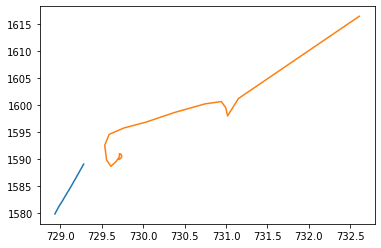

(30, 2)
(30, 5)
[28.7827979  13.89403328 11.03190333 12.85252926 14.27356161 14.14617658
 12.81394519 11.36437678 10.60611186  9.82485974  8.14048369  5.68325016
  5.28518961  6.4161763   7.62196087  8.37310884  8.75263924  9.19454974
  9.42205021  9.61020954 10.12173045 10.33672783 10.54900375 10.68298206
 10.99075904 11.23370853 11.49245817 12.02231975 12.26098051 12.48389336]


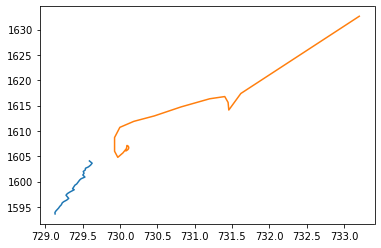

(30, 2)
(30, 5)
[23.77947528  8.78854785  5.87029669  7.50281779  8.8059136   8.65281555
  7.24592785  5.6801893   4.86794375  4.00826462  2.31325908  0.26887105
  0.8242085   0.6762697   1.64041704  2.28561409  2.80746721  3.23731386
  3.24231705  3.38150645  4.06491396  4.19397899  4.51045242  4.68734168
  4.89551286  5.08400299  5.51997826  6.29129899  6.4356734   6.73409213]


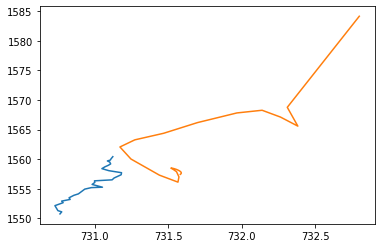

(30, 2)
(30, 5)
[22.96689096  7.7340927   4.6124392   6.17938512  7.26517138  6.96914417
  5.38749334  3.5994402   2.52949556  1.41988696  0.55173336  3.13808477
  4.07550109  3.15727154  2.13998733  1.61618148  1.30149997  1.1556652
  1.10733172  1.03024061  0.75282178  0.67346798  0.57813844  0.48016163
  0.40280311  0.39025909  0.43481236  0.87355158  1.08575518  1.32136465]


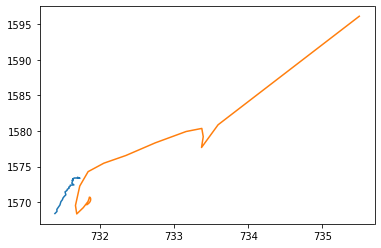

(30, 2)
(30, 5)
[30.11360465 15.45100918 13.60348894 16.2744867  18.52376871 19.33654086
 18.94743001 18.43231084 18.412162   18.28844144 17.20521747 15.37765711
 15.0905371  16.77942583 18.55482154 19.82498245 20.98904543 21.93569615
 22.72008778 23.58567726 24.37197585 25.17384778 26.16653903 26.95820426
 27.88255056 28.76996523 29.49273548 30.51568294 31.26472476 32.25864723]


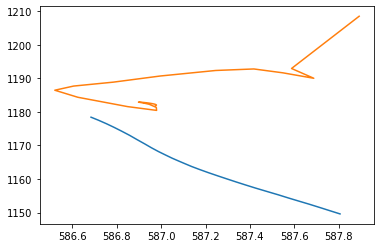

(30, 2)
(30, 5)
[30.67883034 15.58905391 13.14929422 15.28928333 16.94116995 17.14283999
 16.12891498 14.75496644 14.23919107 13.52233464 12.13708009 10.19627102
  9.60108355 11.35544738 12.8020408  14.14910198 15.18122496 16.04722586
 16.56192574 17.17932588 17.85131035 18.37323228 19.13402563 19.67856557
 20.36399945 21.17688084 21.55525227 22.05828048 22.79626747 23.39060192]


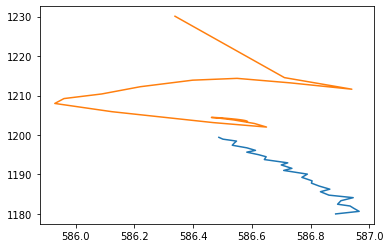

(30, 2)
(30, 5)
[22.90076193  7.76441613  5.30044854  7.35517233  9.00271026  9.05974924
  8.0326728   6.80910039  6.24880806  5.79289681  4.54544863  2.60432326
  2.24644546  3.85541193  5.44365503  6.61376001  7.82535987  8.47580087
  8.63357499  9.22687895  9.8488337  10.40791803 10.92491726 11.20245284
 11.9638686  12.7398608  12.97000958 14.00879659 14.28829073 15.17418528]


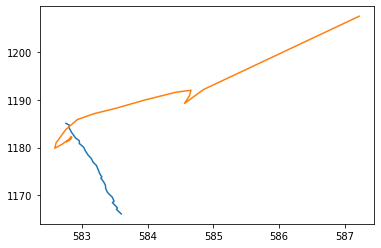

(30, 2)
(30, 5)
[22.49334401  7.24810557  4.45161354  6.2011161   7.53636384  7.08087317
  5.91554202  4.31171122  3.48845696  2.62182464  1.11228369  1.38000511
  2.01883814  0.77067125  1.20639284  2.14130066  3.83835554  4.06089806
  5.09868207  5.63671433  5.80039006  6.28339022  7.00583468  7.15056928
  8.48575084  9.31681569  9.58646828  9.46865333 10.85161836 11.4318486 ]


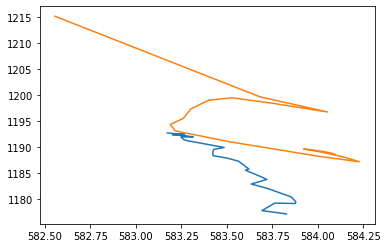

(30, 2)
(30, 5)
[23.5190022  21.62421966 20.25625927 21.27826568 21.97969493 23.45556206
 25.84646545 29.14504106 31.83666724 33.63660804 34.81084614 34.88044913
 34.56879024 34.4474846  34.67736451 35.21847782 35.99833436 36.18793245
 35.94704754 36.39485034 37.85432789 39.25953154 40.52939816 41.71221609
 42.71797679 43.68549431 44.66019252 45.75769137 46.76083929 47.88515595]


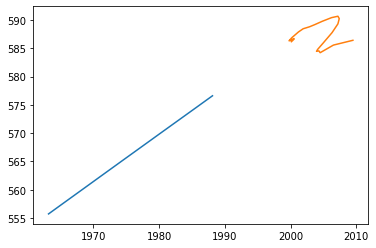

(30, 2)
(30, 5)
[23.92781902 21.93534067 20.60935175 21.60415044 22.33380565 23.68586687
 26.06884896 29.30640389 31.99112213 33.60962922 34.79874322 35.08345604
 34.72021151 34.57885533 34.78024782 35.14841638 35.96007054 36.02870898
 35.65517653 36.27681908 37.71594123 39.05426761 40.36157973 41.46955642
 42.52655026 43.50281275 44.36123639 45.4153607  46.38284365 47.45495736]


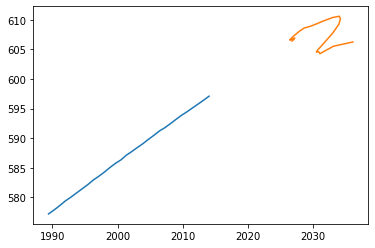

(30, 2)
(30, 5)
[34.21546629 32.79821667 31.98195058 33.70130983 34.82751393 36.74278844
 39.97240591 43.65663855 46.93025654 48.94305762 50.59312763 51.6799611
 51.44065381 51.80124568 52.52670034 53.55719745 55.04937595 55.27681289
 55.81451263 56.41041212 58.32391169 60.21921897 61.94296343 63.50082941
 64.97666338 66.66608403 68.10126292 69.83825678 70.80059403 72.25802509]


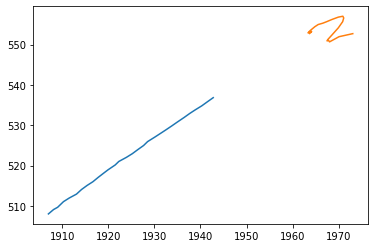

(30, 2)
(30, 5)
[6.5148439  4.82215876 5.41323382 5.09394376 5.08973112 4.7916248
 3.84529654 3.1619277  3.45192238 3.72265779 3.5977315  2.62625788
 1.11583875 0.38701289 0.93686994 1.54190962 1.98635942 2.87781505
 4.17519698 5.29581734 4.89624582 4.78839039 4.74598054 4.75818285
 4.64899785 4.78242801 5.10055231 5.21436082 5.31024282 5.39274791]


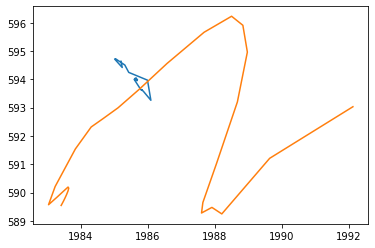

(30, 2)
(30, 5)
[45.6585108  20.02282112 13.38681351 18.82025612 18.26700961 20.6268489
 20.9068621  22.57594326 23.24903604 24.55360198 25.3441733  26.63656251
 27.51192978 28.75220239 29.58789233 30.73606942 31.64173642 32.75376129
 33.72350923 34.81957721 35.94098315 36.92327783 38.0731028  39.16469959
 40.22616651 41.53940093 42.50164441 43.59891905 44.78931962 45.76938183]


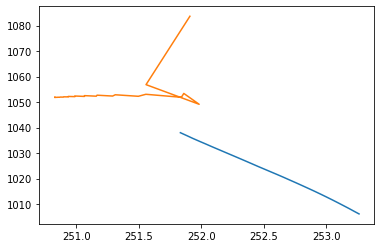

(30, 2)
(30, 5)
[39.65851548 25.31795937 22.83424271 25.14075354 28.05523566 28.56307198
 26.85491819 26.24381021 26.94947463 26.45056585 24.33220069 22.35750501
 23.43180591 24.51335747 26.26708138 27.65609247 29.51503702 30.56336038
 30.74920499 31.47885668 32.36544569 33.39373296 34.21276033 35.37825527
 36.24328545 37.19473465 38.35694175 40.17526787 40.28471938 41.41526244]


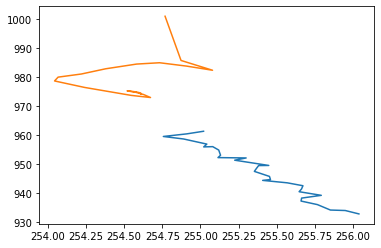

(30, 2)
(30, 5)
[34.50146774 19.82964999 16.89781046 18.73694693 20.38384741 20.57985549
 19.55953939 18.2103556  16.93531918 14.69713604 12.22599719 12.12585862
 13.66524862 15.02033687 15.79003786 16.16448662 16.51430399 16.86592879
 17.1018476  17.37813883 17.55966711 17.75132703 18.05074866 18.34467949
 18.61269525 18.88442604 19.17642417 19.46110374 19.42102612 19.49978403]


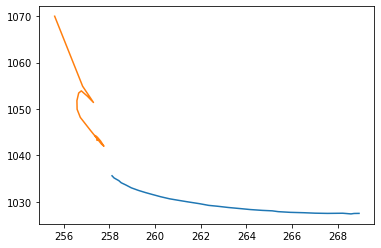

(30, 2)
(30, 5)
[25.3929914   1.69543855  8.34225005  4.35688742  5.65976443  4.535462
  5.40391412  3.0588995   3.41592547  2.85555975  3.3723316   3.08452604
  2.71691396  2.54617604  2.80218412  2.76426422  5.28100381  4.89406788
  5.00053955  3.0109681   2.95883569  3.01077328  3.01017613  3.04384519
  3.02539571  2.99335973  3.09371622  3.04857951  3.10865458  3.00519253]


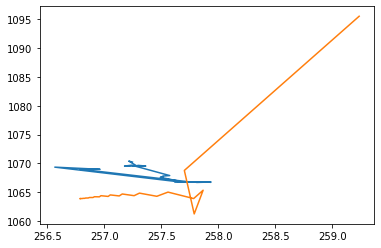

(30, 2)
(30, 5)
[24.4584923  22.51420369 21.18666688 22.35797231 23.09436416 24.50131012
 27.02768601 30.24591615 32.85114272 34.88534947 36.07194028 36.25697828
 35.94984337 35.82073532 36.15596374 36.69360386 37.35221179 37.53612816
 37.2797084  37.71424657 39.15685274 40.54941466 41.90964546 42.96896614
 43.95255884 45.01429387 45.86077924 46.93626468 47.91736053 49.01421358]


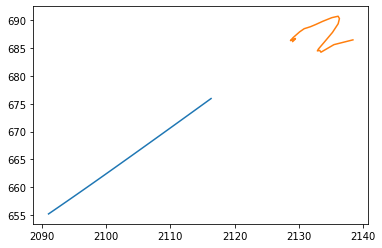

(30, 2)
(30, 5)
[37.32927961 36.32719057 35.89361612 37.15270813 38.70710391 41.01538513
 44.20973984 48.19312282 51.95910205 54.20678248 56.16544616 57.11098145
 57.51816194 58.25717143 59.43973836 60.61487549 62.23190063 63.20962501
 63.64850677 64.94665689 67.14287481 69.37594898 71.47782698 73.38574558
 75.24247289 77.10395744 78.94038399 80.76077397 82.62712284 84.54672693]


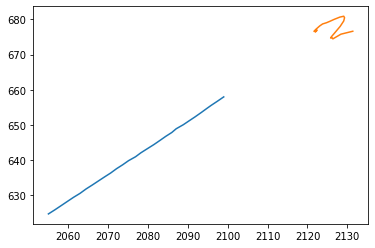

(30, 2)
(30, 5)
[32.14230638 30.88218585 29.96723577 31.71334283 32.90546749 34.81251251
 37.84445719 41.69073315 44.92567362 47.35454791 49.12520849 49.7819879
 49.8343223  50.27301218 50.94479898 51.87329406 53.29708592 53.92169362
 54.15837988 54.99757144 56.93601615 58.65770577 60.60585995 62.08679191
 63.98770064 65.30820248 66.95177689 68.60911502 70.05991366 71.45346752]


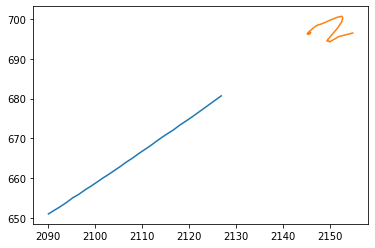

(30, 2)
(30, 5)
[30.91940784 29.50730469 28.2249933  29.79439474 31.12497184 32.95222162
 35.98757736 39.90650345 43.08519976 45.51590839 46.97422088 47.63775777
 47.4984834  48.18809337 48.79836319 50.04065333 51.05787481 51.82511767
 52.15024976 53.03870727 55.13083469 57.12382452 58.98509903 60.61345632
 62.1473353  63.6737149  65.25077163 66.85540338 68.3328679  70.02332217]


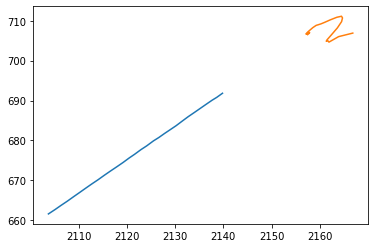

(30, 2)
(30, 5)
[ 3.17604983  2.95472044  4.59581077  5.16565486  4.78062412  4.09982415
  3.22544593  2.25888559  1.23078435  0.88066133  1.60853769  2.60281723
  3.66179971  4.43601155  4.99277697  5.49795886  5.75918543  6.21159182
  6.70946335  7.50590775  8.69320919 10.00026278 11.40675065 12.80313639
 14.2340328  15.47022476 16.62269239 17.70605547 18.84669399 19.85637395]


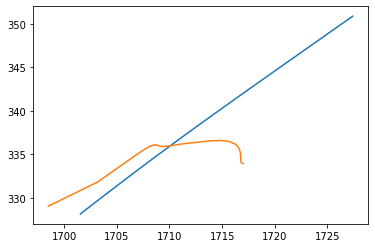

(30, 2)
(30, 5)
[19.80509258 24.94784916 28.03822648 29.71785776 30.67920573 30.99332071
 31.27382491 31.48102697 31.51437354 31.63901264 31.67451303 31.63621085
 31.29136373 31.51841967 32.00040034 32.85914105 33.55767726 34.60083151
 35.37924144 36.1108488  36.46650057 36.30892441 36.28720084 36.07936299
 35.93329714 35.67958626 35.6435216  35.69100044 35.73416128 35.80978523]


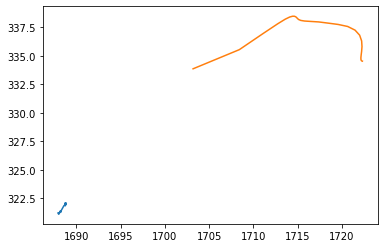

(30, 2)
(30, 5)
[ 9.35252002 14.37760223 17.15010244 18.78873321 19.42496657 19.75250971
 19.45057328 19.4848455  19.30909044 18.93991304 18.67488922 18.57131142
 18.54935008 18.65375759 19.09035892 19.6980694  20.39091625 21.36466755
 21.91385701 22.62572364 22.98215457 22.65115839 22.42637226 22.06769404
 21.86239382 21.56378989 21.93297479 21.78745191 21.77164969 21.46630687]


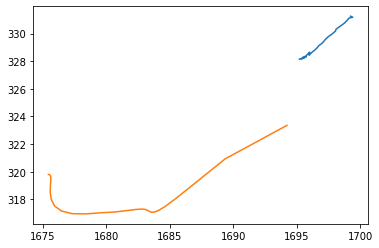

(30, 2)
(30, 5)
[ 3.20721173  6.55173883  7.24318214  7.0562602   7.07070745  7.11291045
  7.33598023  7.72315265  8.23894267  8.71790345  9.18799261  9.6472471
 10.04305257 10.38932635 10.72598061 11.04652638 11.35581504 11.65751365
 11.95623624 12.25717338 12.56656312 12.89182712 13.24150467 13.62470653
 14.05011615 14.52473266 15.05266323 15.63429102 16.26596073 16.94011299]


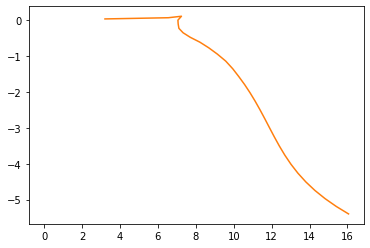

(30, 2)
(30, 5)
[10.89648304 13.0048515  12.87370776 13.17249117 12.95220809 13.09598504
 13.77281933 15.2741784  17.23431078 19.23200359 20.66789833 21.67529225
 22.13932023 21.84135324 20.93471265 19.695022   18.09580808 16.87581614
 17.30756279 18.46328859 19.24180775 19.73525095 20.11051844 20.40467498
 20.70893073 21.01068462 21.27730379 21.57537462 21.84383325 22.10907989]


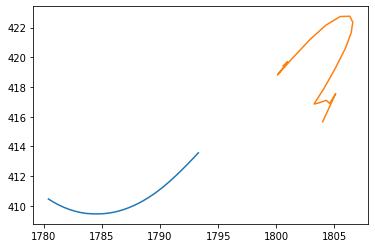

(30, 2)
(30, 5)
[16.81625988 16.71407907 15.00989615 15.30548209 15.32363847 16.02250552
 16.75750744 19.55013033 21.93251336 23.74191314 24.93194559 25.39342359
 24.94893234 23.97019434 22.43840263 19.77389462 18.40592682 19.38355085
 20.72572789 21.69741921 22.31801392 22.76095684 23.17079308 23.51851395
 23.92729891 24.32882517 24.75064126 25.14886337 25.49358404 25.88829555]


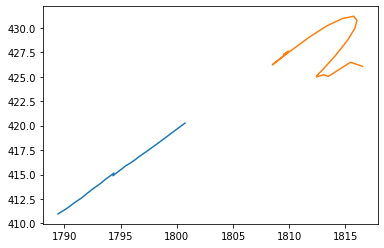

(30, 2)
(30, 5)
[19.95768095 21.48459721 22.76408205 24.41702956 26.71164887 28.62188856
 28.76129216 31.2022417  32.17400993 33.89667893 36.35501769 39.15966241
 41.6280512  43.76136506 45.35171479 46.51917841 47.24226992 47.4812523
 47.39674237 47.167967   45.68310453 47.72385105 49.42710551 50.93996682
 52.24115087 53.41463035 53.35434931 55.66476584 56.58348198 56.53023332]


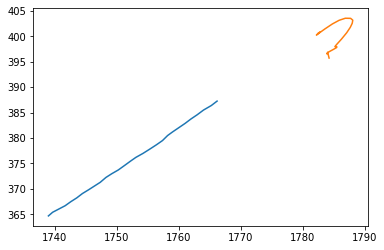

(30, 2)
(30, 5)
[25.81240315 25.27989997 23.88542655 25.07873628 25.55460235 27.01908527
 27.91947148 32.3114754  35.41476728 37.88761387 39.6771619  40.72488676
 40.57284382 40.02572734 39.20711239 37.76638134 37.79426224 40.21442471
 42.22054517 43.86906282 45.09537055 46.40861988 47.59493159 48.67658464
 49.97130831 51.16212567 52.30664001 53.50846394 54.64683789 55.97330921]


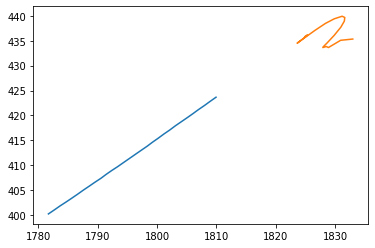

(30, 2)
(30, 5)
[33.20409611 18.5881656  16.25597344 18.65298212 20.53522188 20.80236577
 20.02376042 18.89486518 18.51598604 17.97745487 16.51651826 14.34173669
 13.69390372 15.15307875 16.55722969 17.48641097 18.15986776 18.56070331
 18.90441218 19.18399973 19.39865768 19.61797869 19.85406733 20.09398011
 20.32035344 20.53589292 20.6912056  20.86803287 21.02177869 21.11995936]


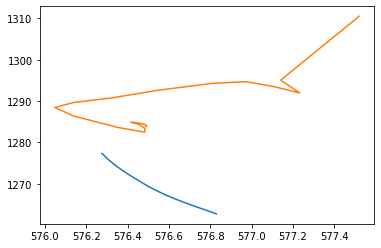

(30, 2)
(30, 5)
[35.43568737 21.01212429 18.48243431 20.50475001 22.66133484 22.66265255
 21.99343125 20.66207971 20.41847344 19.69778612 18.70857635 16.2946186
 15.54471106 17.03320521 18.33825869 19.3671276  19.88440123 20.12708907
 20.59105912 20.65919714 20.76930838 20.90930401 21.2557866  21.36941031
 21.40862768 21.352586   21.47815936 21.61814905 21.78278155 21.90201855]


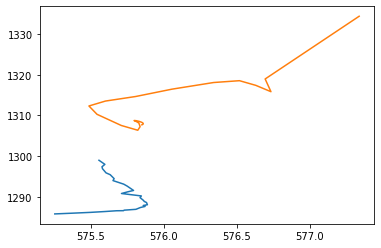

(30, 2)
(30, 5)
[38.95361583 24.91272431 22.5190424  24.77330345 27.28097948 27.63118567
 27.33461282 26.13692277 26.31191596 25.72383191 24.84521883 22.78793496
 22.22433293 24.20777053 25.6317591  27.04661563 27.71726566 28.19089431
 28.96272948 29.25238697 29.50731717 29.72801468 30.29185208 30.45321187
 30.57495495 30.94532711 31.16354914 31.3027326  31.45367038 31.51152103]


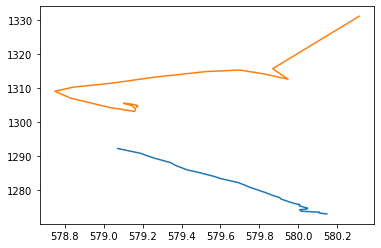

(30, 2)
(30, 5)
[22.6425559   7.28104557  4.34902555  5.96346042  7.0878885   6.62655276
  4.95987529  3.04816829  1.63841044  0.45163213  1.6576166   4.58541896
  5.72484317  4.94823531  3.92039538  3.49188246  3.25137649  3.34744832
  3.40885942  3.51763022  3.61604119  3.74050306  4.08761957  4.18649787
  4.34203839  4.362989    4.44509193  4.65399996  4.50836476  4.56564318]


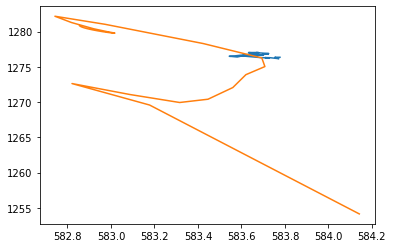

(30, 2)
(30, 5)
[45.11447259 30.56696506 28.94319924 31.7254022  34.06353986 34.66494967
 34.0766639  33.34686037 33.28440426 33.08999853 32.02631982 30.28797501
 30.20956924 32.07457924 34.15335157 35.63060623 36.92136609 37.97523371
 38.88751742 39.92312352 40.86750671 41.81790015 42.95298757 43.9198857
 44.89933237 45.8836719  46.95962587 48.04582792 49.135214   50.31856739]


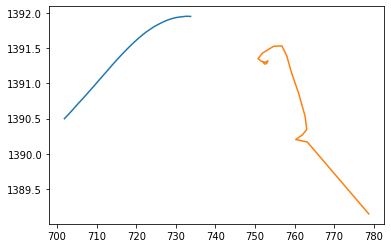

(30, 2)
(30, 5)
[53.68998255 39.06078408 38.61020176 41.47208838 44.75963423 45.34900575
 45.08126632 45.21761467 45.70362123 45.49040576 44.13614301 43.78979005
 43.6177727  45.91241547 48.11137109 49.63960401 50.75190217 53.06387362
 53.84678385 54.89550871 55.7849344  56.61534854 59.011948   59.60991219
 60.57276488 61.73054858 62.81031883 64.72937631 65.96432895 66.76442586]


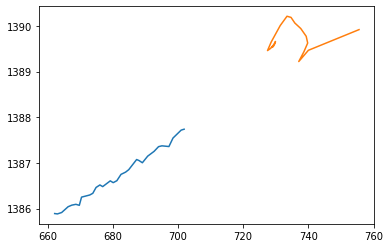

(30, 2)
(30, 5)
[39.04065553 23.87741031 21.7860551  23.78511273 25.70578333 25.60453679
 24.36342941 23.13238164 22.39702159 21.45975491 19.74142263 17.59002106
 16.84377141 17.86803266 19.16083831 19.81146947 20.27253868 20.89321422
 21.15825287 21.23460768 21.29993151 21.76811719 22.12371624 22.24432614
 22.8957946  22.94741861 23.18331718 23.09978084 23.67081784 24.70312625]


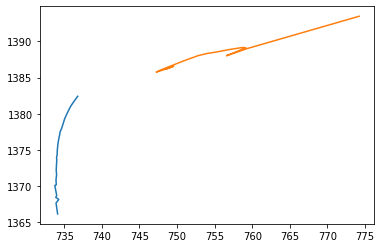

(30, 2)
(30, 5)
[34.24601399 19.04759131 17.44571187 19.93067759 22.53561047 22.81071855
 21.75694571 21.06893282 20.66530572 20.12373899 18.57776804 16.94423717
 16.55582383 17.96438483 19.50872086 20.52854787 20.20787344 22.1478088
 21.96382018 25.82229816 25.04593375 24.23945117 25.90716762 25.01400995
 25.86180068 25.78612756 25.88510063 26.31423467 28.43491985 31.18178741]


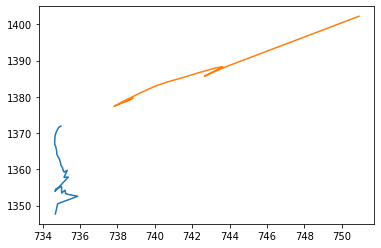

(30, 2)
(30, 5)
[8.43838094 7.46493821 7.99552642 7.50406616 6.80467821 6.43044372
 6.33409893 6.35966833 6.28661287 5.72127105 4.58301685 3.43699974
 2.70937889 2.30621965 2.00774701 1.47110978 0.80370516 1.34333076
 2.63698902 4.27430264 5.59999629 5.64017662 5.15266287 4.92740855
 4.8717675  4.91463324 4.97626701 5.04269638 5.10103722 5.15273673]


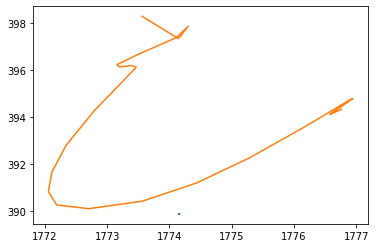

(30, 2)
(30, 5)
[6.17941101 4.86854703 5.7502232  5.49034277 5.7604774  5.48771512
 4.60691762 3.28965881 2.84438411 3.06055598 3.04133356 2.38337216
 0.90919948 1.38051524 3.90848209 6.91868375 7.91519485 6.6683089
 6.0067219  4.23529201 4.3409791  4.57705574 4.88281905 4.98345941
 4.98755432 5.11390777 5.19265767 5.23389226 5.24491229 5.33175801]


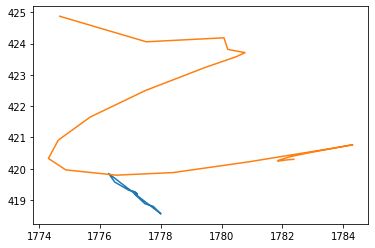

(30, 2)
(30, 5)
[ 33.04159115  36.12374953  37.31735442  38.96439566  42.34889301
  44.30092464  47.2787812   49.64387395  50.92095546  53.3499735
  56.15894233  59.73293641  63.70548191  66.93225028  70.03328195
  72.66679512  73.38708635  75.04867954  75.18126273  76.28910088
  77.61981234  79.68256028  83.18489216  86.2357972   89.25967088
  92.07849563  94.94136719  97.64696792 100.36580859 104.73889535]


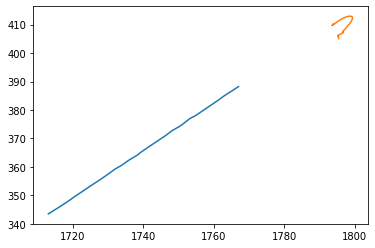

(30, 2)
(30, 5)
[ 3.20721173  6.55173883  7.24318214  7.0562602   7.07070745  7.11291045
  7.33598023  7.72315265  8.23894267  8.71790345  9.18799261  9.6472471
 10.04305257 10.38932635 10.72598061 11.04652638 11.35581504 11.65751365
 11.95623624 12.25717338 12.56656312 12.89182712 13.24150467 13.62470653
 14.05011615 14.52473266 15.05266323 15.63429102 16.26596073 16.94011299]


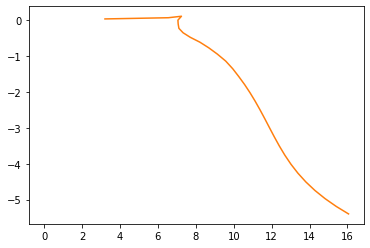

(30, 2)
(30, 5)
[24.49728045 22.55323352 21.22611283 22.29414649 23.03298688 24.54791812
 26.85832853 30.18209385 32.89401282 34.70911672 35.89865982 36.19423153
 35.76516596 35.62277906 35.92681547 36.41280595 37.10961395 37.00920684
 36.55780433 36.88865678 38.22102847 39.49729342 40.82504348 41.66271411
 42.5280305  43.4501132  44.28455718 45.12950471 45.99781945 46.97416098]


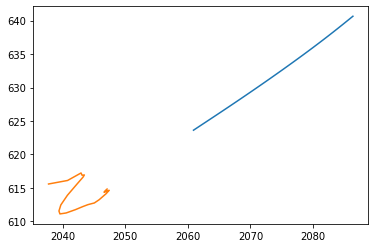

(30, 2)
(30, 5)
[23.99993422 22.18178672 21.04439536 22.20597796 23.17895286 24.56357198
 27.19423787 29.31466269 33.44306062 35.4873597  36.82453043 37.2116593
 37.10606803 37.17457891 37.63882887 38.47418373 39.35434505 39.84473884
 39.77924244 40.48570741 42.26577591 43.97740699 45.58979431 47.01706081
 48.39477714 49.66114618 50.97910282 52.27457572 53.70032827 55.12501119]


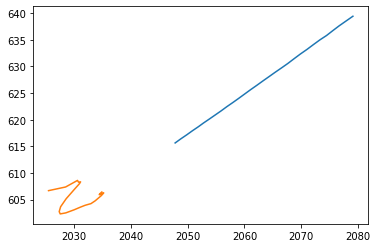

(30, 2)
(30, 5)
[25.58999736 23.53063129 22.27021267 23.39097833 24.11834193 26.07645739
 28.39280089 30.51735704 34.11906315 36.25312341 37.44669383 37.81041987
 37.55672224 37.47649153 38.02120101 38.57276551 39.44574158 39.42295602
 39.35265456 40.0980604  41.68939862 43.37527317 44.87657506 46.21833372
 47.3886013  48.40401909 49.61212464 50.90622202 52.01565284 53.37852792]


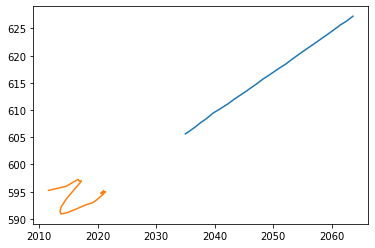

(30, 2)
(30, 5)
[35.06482829 33.65163968 33.17018633 34.88426909 36.34985902 38.59692971
 41.7128796  43.86340584 48.96831867 51.45171969 53.33237803 54.34684405
 54.64992309 55.212331   56.2205469  57.41819115 58.85015494 59.77920953
 60.06942596 61.29530982 63.47071974 65.78936206 67.59983868 69.51827254
 71.24114685 72.89668556 74.62971019 76.41905918 78.14075282 79.86649817]


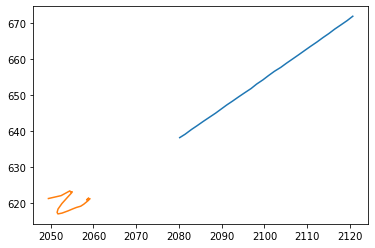

(30, 2)
(30, 5)
[22.20333002  6.98809732  4.23787288  6.01314229  7.39399467  7.20056552
  5.8218427   4.26021819  3.40190775  2.39951414  0.59200181  2.03563066
  3.09465588  2.13488846  1.25045142  0.83941907  0.6660594   0.68434835
  0.75574023  0.87027488  0.98054991  1.09134602  1.18927982  1.27992523
  1.35988253  1.43234504  1.49617161  1.55422412  1.60548015  1.6525782 ]


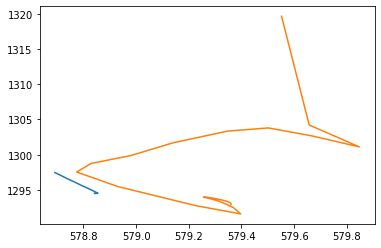

(30, 2)
(30, 5)
[25.26060434 10.09548613  7.32950688  9.16993621 10.72321434 10.44941769
  9.07816915  7.47556276  6.54427204  5.49660992  3.7835022   1.2684535
  0.5074833   1.28202649  2.17384105  2.98378171  3.2273251   3.29295996
  3.525535    3.460639    3.3173144   3.44761744  3.44544468  3.43484305
  3.39306679  3.44907626  3.42922903  3.39436851  3.35240432  3.33106426]


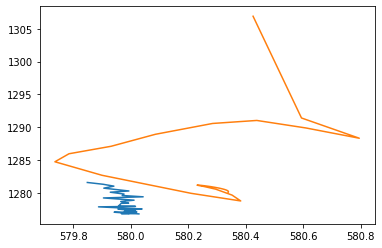

(30, 2)
(30, 5)
[21.65028147  6.22254152  3.3148926   4.67652546  5.80980022  5.33136939
  3.71252736  1.84748797  0.72734481  0.50900951  2.55490385  5.31943219
  6.44483517  5.61418311  4.68426641  4.27896733  4.08139624  4.15152733
  4.18038857  4.30520872  4.43659972  4.54678298  4.65994592  4.75545691
  4.83417662  4.92243201  5.00450221  5.08921321  5.11117575  5.17201557]


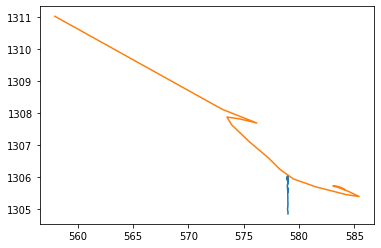

(30, 2)
(30, 5)
[38.27594327 23.86476514 21.8408124  24.38755699 26.91365632 27.26013913
 26.33418905 25.33296037 24.81485548 24.05005148 22.41830368 19.85045745
 18.94961869 19.93642539 21.09652793 21.37356588 21.55287867 21.6527058
 21.46907956 21.52133117 21.223015   21.11257668 21.0178343  20.92845676
 20.82271643 20.74297605 20.67289494 20.62388998 20.54776507 20.50987725]


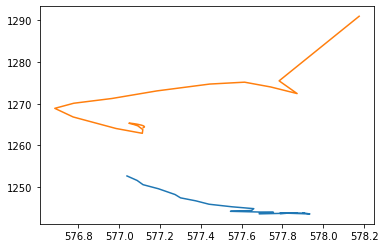

(30, 2)
(30, 5)
[39.32460167 24.7380663  22.64083069 25.20853361 27.14678531 27.64343056
 26.84828752 25.86803389 25.55228774 25.2278242  23.95245002 21.97680483
 21.60378175 23.3377909  25.75419981 26.89861991 27.90540659 28.52729542
 29.22589234 29.85520764 30.40366334 31.01279174 31.03848587 31.58523647
 32.13384952 32.73263325 33.26501266 33.79514826 34.37188339 34.87878006]


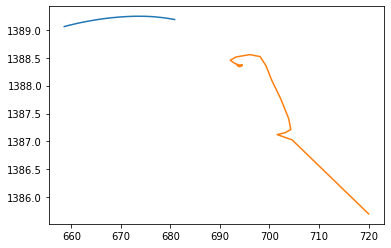

(30, 2)
(30, 5)
[37.7101513  22.99277858 20.83769543 23.30434686 25.33935602 25.77873613
 24.92691892 24.0513487  23.69575104 23.31952946 22.09827349 20.26563002
 19.90648548 21.58257737 23.3759876  24.6086061  25.70424653 26.52469117
 27.27052589 27.98829219 28.72321147 29.50191803 30.21354248 30.9842183
 31.84063413 32.44757765 33.12950053 33.91751393 34.61069579 35.37812354]


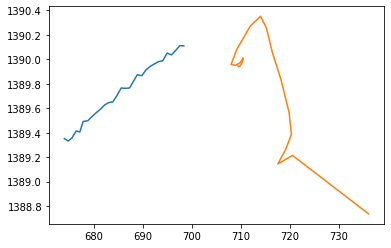

(30, 2)
(30, 5)
[33.26868608 18.15640651 15.70168949 17.79260405 19.28660353 19.25430816
 19.12987409 17.96838262 17.53599983 17.6618667  15.80988305 13.11155103
 12.70577461 13.92921924 15.83248395 15.55302881 16.91569849 18.03931544
 18.12035728 18.24548144 19.6494075  20.19483032 20.69105712 21.28018444
 21.36964564 22.32858591 23.20144564 23.37809674 23.72600936 24.22173061]


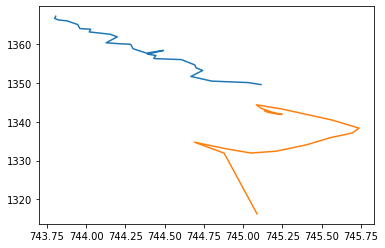

(30, 2)
(30, 5)
[34.52663415 19.52378679 17.02828146 19.07370922 20.8354929  20.87130149
 19.76915403 18.41457587 17.80899141 17.11387131 15.64582382 13.44861659
 12.80051935 14.19708891 15.685859   16.61441001 17.36345973 17.86534932
 18.22882599 18.7053247  19.12159202 19.48761951 19.83311824 20.1998882
 20.6163999  21.11669982 21.56205174 21.97264713 22.49491977 22.91253997]


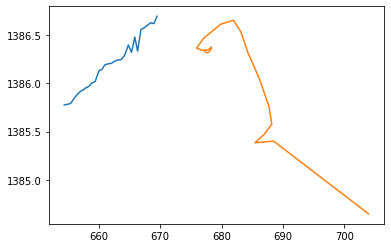

(30, 2)
(30, 5)
[23.98698707 22.00361802 20.65336542 21.79453737 22.51320605 23.8977112
 26.30043658 29.50289461 32.31166143 34.11495927 35.40803564 35.58954901
 35.17242462 35.05171066 35.50302321 35.93626062 36.60564821 36.79814772
 36.4518888  37.0139547  38.48159028 40.00516891 41.16554428 42.36199164
 43.37620801 44.46653586 45.23315249 46.34318778 47.47137232 48.61066329]


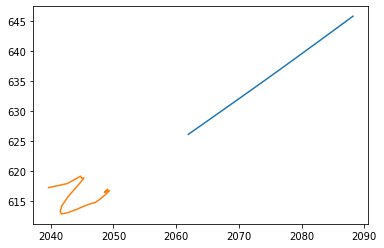

(30, 2)
(30, 5)
[29.16937336 27.44407898 26.49220278 27.71628884 28.53717193 30.27774865
 33.00694314 36.48983192 39.38614821 41.46456271 42.93322494 43.40570798
 43.23881205 43.32528135 43.8339515  44.6147343  45.54153451 45.97486511
 45.79233251 46.67884304 48.48718013 50.09435772 51.52987314 52.86473748
 54.15746898 55.59035528 56.68114856 57.96418292 57.86844272 60.59014608]


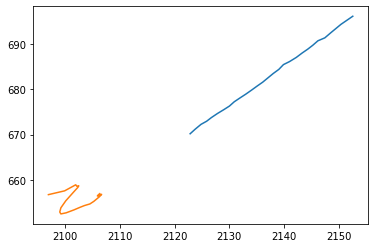

(30, 2)
(30, 5)
[36.58452657 35.32867332 34.59606639 36.28345101 37.66231763 39.49997334
 42.51147977 46.35233948 49.90597327 52.07172137 53.75552597 54.72915312
 54.74844888 55.1933022  55.98540428 56.86349404 58.08503128 58.68720968
 58.90773739 59.86613356 61.89049194 63.87434435 65.52719547 67.07078658
 68.65735877 70.12317987 71.56690901 72.94924979 74.4029271  75.94477255]


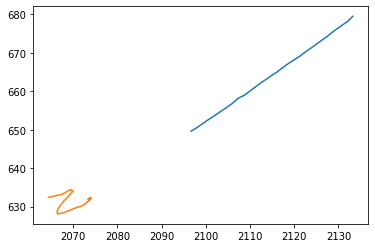

(30, 2)
(30, 5)
[20.19276636 18.09455067 16.69275459 17.7765568  18.34739749 19.7011796
 22.05189351 25.28769236 28.07825719 29.82257204 31.11399592 31.26760179
 30.92315021 30.80144147 31.2169983  31.71947921 32.66779916 32.86838399
 32.65506305 33.15000028 34.68643843 36.37197808 37.68638358 39.0651871
 40.06502112 41.21804494 42.35248654 43.51955023 44.69411475 45.88684254]


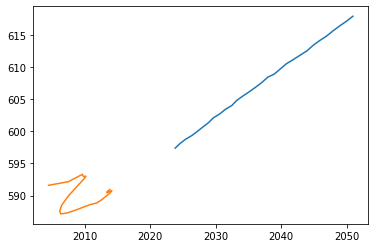

(30, 2)
(30, 5)
[40.30634643 26.20002206 23.62264168 26.08777723 28.2527224  28.81547579
 28.32131374 27.45751587 27.55556372 27.41734991 26.71867857 25.04713413
 24.8479624  26.74281413 28.64046458 30.19525506 31.26444912 32.28229776
 33.3311676  34.25609459 35.18450324 36.12373719 37.07477544 38.03976768
 39.01847755 40.1147176  41.11679581 42.12769692 43.14616314 44.28693769]


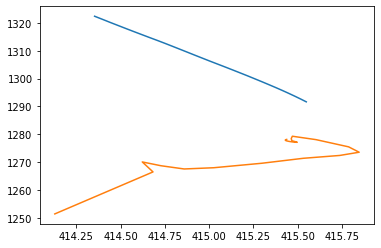

(30, 2)
(30, 5)
[37.91899264 23.36074889 20.81991667 23.08902443 25.05436128 25.25604886
 24.36970497 23.38697451 23.16454948 22.83733194 21.68819176 19.81119237
 19.14741596 20.91929643 22.43834491 23.42841698 23.97713317 25.13907086
 25.5973135  25.88822585 26.73999138 27.27873235 27.33851456 27.94573031
 28.90420439 28.82381993 30.2285484  32.40402911 32.57900462 33.3570434 ]


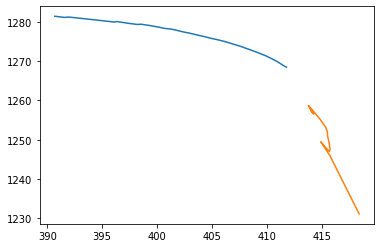

(30, 2)
(30, 5)
[21.80170378  6.69857674  3.30405098  4.58569527  5.70412007  5.28652068
  3.68991476  1.8624832   0.8376397   0.42665191  2.31170355  4.80258335
  6.07785525  5.27837477  4.44395599  3.99417679  3.90161664  3.77619759
  3.8637903   4.0782604   4.07327847  4.08061115  4.34859464  4.34732201
  4.44500259  4.47358433  4.4097334   4.42600837  4.49186617  4.54325686]


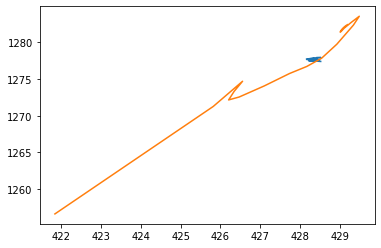

(30, 2)
(30, 5)
[22.70921003  7.43457067  4.1148569   5.39270962  6.39849939  5.98493621
  5.52601227  3.79847933  2.53196261  1.3091652   0.82661314  3.40558404
  4.65015718  3.77740703  3.00166519  2.51350257  2.48648057  2.71875206
  3.11066923  3.54178599  3.02182752  3.1474317   3.09489528  3.3267202
  3.41150174  3.67026502  3.80976088  3.95646264  3.30437797  3.30197046]


KeyboardInterrupt: 

In [362]:
for k, f in forecasted_trajectories.items():
    gt = np.array(test_output[k])
    f = f[0]
    print(gt.shape)
    print(f.shape)
    
    ade = np.sqrt((f[:,0] - gt[:,0])**2 + 
                (f[:,1] - gt[:,1])**2)
    print(ade)
    
    plt.plot(gt[:,0], gt[:,1])
    plt.plot(f[:,0], f[:,1])
    plt.show()


In [ ]:

de[i] = torch.sqrt((decoder_outputs[:,:,0] - target[:,0])**2 + 
                (decoder_outputs[:,:,1] - target[:,1])**2)
coverage[i] = get_coverage(decoder_outputs, target)


In [208]:
car_mask =  np.stack(rose_val_df['car_mask'].tolist())
car_mask = car_mask.squeeze()
car_mask.shape

(3023, 60)

In [202]:
filte =  np.where(car_mask == 1)

In [205]:
filte

(array([   0,    0,    0, ..., 3022, 3022, 3022]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 0,  1,  2, ...,  9, 10, 11]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [204]:
[f.shape for f in filte]

[(23995,), (23995,), (23995,), (23995,)]

In [193]:
rose_val_df['p_in'][1][0].shape

(60, 19, 2)

In [147]:
agentid_scene = {v:k for k,v in scene_agaentid.items()}

In [116]:
len(ids)

3023

In [146]:
[i for i in ids if '14164' in i]

['00000000-0000-0000-0000-000000014164']

In [148]:
agentid_scene[14164]

10019

In [117]:
scene_agaentid[10019]

14164

In [15]:
len(ids)

3022

In [60]:
ids_i = [int(i[0][-12:]) for i in ids]

In [92]:
yes = []
no = []
for s in subsubset:
    if s in feats_set:
        yes.append(reverse_lookup[s])
    else:
        no.append(reverse_lookup[s])

In [89]:
print(len(yes), len(no))

111 88


In [96]:
[lookup[s] for s in [10019, 10028, 10075, 10078]]


[14164, 19889, 6878, 10630]

In [64]:
feats_set =  features_df['SEQUENCE'].tolist()
yes = []
no = []
for s in ids_i:
    if s in feats_set:
        yes.append(s)
    else:
        no.append(s)

In [65]:
print(len(yes), len(no))

1686 1336


In [ ]:
from eval_forecasting_helper import *
import eval_vis_helper as helper

In [3]:
import shlex

parser = argparse.ArgumentParser()
parser.add_argument("--test_batch_size",
                    type=int,
                    default=512,
                    help="Test batch size")
parser.add_argument("--model_path",
                    required=False,
                    type=str,
                    help="path to the saved model")
parser.add_argument("--obs_len",
                    default=20,
                    type=int,
                    help="Observed length of the trajectory")
parser.add_argument("--pred_len",
                    default=30,
                    type=int,
                    help="Prediction Horizon")
parser.add_argument(
    "--normalize",
    action="store_true",
    help="Normalize the trajectories if non-map baseline is used",
)
parser.add_argument(
    "--use_delta",
    action="store_true",
    help="Train on the change in position, instead of absolute position",
)
parser.add_argument(
    "--train_features",
    default="",
    type=str,
    help="path to the file which has train features.",
)
parser.add_argument(
    "--val_features",
    default="",
    type=str,
    help="path to the file which has val features.",
)
parser.add_argument(
    "--test_features",
    default="",
    type=str,
    help="path to the file which has test features.",
)
parser.add_argument(
    "--joblib_batch_size",
    default=100,
    type=int,
    help="Batch size for parallel computation",
)
parser.add_argument("--use_map",
                    action="store_true",
                    help="Use the map based features")
parser.add_argument("--use_social",
                    action="store_true",
                    help="Use social features")
parser.add_argument("--test",
                    action="store_true",
                    help="If true, only run the inference")
parser.add_argument("--train_batch_size",
                    type=int,
                    default=512,
                    help="Training batch size")
parser.add_argument("--val_batch_size",
                    type=int,
                    default=512,
                    help="Val batch size")
parser.add_argument("--end_epoch",
                    type=int,
                    default=5000,
                    help="Last epoch")
parser.add_argument("--lr",
                    type=float,
                    default=0.001,
                    help="Learning rate")
parser.add_argument(
    "--traj_save_path",
    required=False,
    type=str,
    help=
    "path to the pickle file where forecasted trajectories will be saved.",
)
    

In [4]:
import pandas as pd
df = pd.read_pickle('features/val.pkl')

In [6]:
from scipy.stats import multivariate_normal
from tqdm import tqdm
import torch


def nll_loss( pred: torch.Tensor, data: torch.Tensor) -> torch.Tensor:
    loss = 0
    for i, x in enumerate(data):
        mu = pred[i, :2]
        x_sigma = pred[i, 2]
        y_sigma = pred[i, 3]
        rho = pred[i, 4]
        off_diag = rho * x_sigma * y_sigma
        C = np.array([[np.power(x_sigma,2), off_diag], [off_diag, np.power(y_sigma,2)]])
        m = multivariate_normal(mu, cov=C)
        loss += -multivariate_normal.logpdf(x, mean=mu, cov=C)
        
    return loss/data.shape[0]

def metric_nll(forecasted_trajectories, gt_trajectories, horizon = 30):
    nlls = []
    for k, v in tqdm(gt_trajectories.items()):
        pred = forecasted_trajectories[k][0]
        nll = nll_loss_2(pred[:horizon], v[:horizon])
        #print(k, nll)
        nlls.append(nll)
    return np.mean(nlls)

def metric_nll_f(forecasted_trajectories, gt_trajectories, t = 30):
    t = t-1

    nlls = []
    for k, v in tqdm(gt_trajectories.items()):
        pred = forecasted_trajectories[k][0]
        nll = nll_loss_2(np.expand_dims(pred[t], axis=0),np.expand_dims(v[t], axis=0))
        #print(k, nll)
        nlls.append(nll)
    return np.mean(nlls)


def quantile_loss(pred: torch.Tensor, data: torch.Tensor, alpha=0.9) -> Tuple[torch.Tensor, torch.Tensor]:

    x_mean = pred[:, 0]
    y_mean = pred[:, 1]

    x_delta = x_mean - data[:, 0]
    y_delta = y_mean - data[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]

    ohr = np.power(1-np.power(rho, 2), 0.5)

    root_det_epsilon = ohr * x_sigma * y_sigma

    c_alpha = - 2 * np.log(1 - alpha)

    c_ =  (np.power(x_sigma, 2) * np.power(y_delta, 2) \
        + np.power(y_sigma, 2) * np.power(x_delta, 2) \
        - 2 * rho * x_sigma * y_sigma * x_delta * y_delta) * np.power(root_det_epsilon, -2)#c prime

    c_delta = c_ - c_alpha
    c_delta = np.where(c_delta > 0, c_delta, np.zeros(c_delta.shape))
    #  root_det_sigma *  (that - a contant)*scale 
    # idea: scale up the c_delta term -> small displacement, maybe larger interval
    
    mrs = root_det_epsilon * (c_alpha + c_delta/alpha)
    return np.mean(mrs)

def get_coverage(pred: torch.Tensor, data: torch.Tensor, alpha = 0.9):
    x_mean = pred[:, 0]
    y_mean = pred[:, 1]

    x_delta = x_mean - data[:, 0]
    y_delta = y_mean - data[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]

    ohr = np.power(1-np.power(rho, 2), 0.5)

    root_det_epsilon = ohr * x_sigma * y_sigma

    c_alpha = - 2 * np.log(1 - alpha)

    c_ =  (np.power(x_sigma, 2) * np.power(y_delta, 2) \
        + np.power(y_sigma, 2) * np.power(x_delta, 2) \
        - 2 * rho * x_sigma * y_sigma * x_delta * y_delta) * np.power(root_det_epsilon, -2)#c prime

    cover = np.where(c_ < c_alpha, np.ones(c_.shape), np.zeros(c_.shape))
    return cover    

def nll_loss_2(pred: torch.Tensor, data: torch.Tensor) -> torch.Tensor:
    """Negative log loss for single-variate gaussian, can probably be faster"""
    x_mean = pred[:, 0]
    y_mean = pred[:, 1]
    x_delta = x_mean - data[:, 0]
    y_delta = y_mean - data[:, 1]
    x_sigma = pred[:, 2]
    y_sigma = pred[:, 3]
    rho = pred[:, 4]
    root_det_epsilon = np.power(1-np.power(rho,2), 0.5) * x_sigma * y_sigma
    loss = np.log(2*3.14159*root_det_epsilon) \
            + 0.5 * np.power(root_det_epsilon, -2) \
                * (np.power(x_sigma, 2) * np.power(y_delta, 2) \
                + np.power(y_sigma, 2) * np.power(x_delta, 2) \
                - 2 * rho * x_sigma * y_sigma * x_delta * y_delta)
    
    # log(2 pi root_det_sigma) + 0.5 * that
    return np.mean(loss)



def metric_quantile(forecasted_trajectories, gt_trajectories,  horizon = 30):
    qs = []
    for k, v in tqdm(gt_trajectories.items()):
        pred = forecasted_trajectories[k][0]
        q = quantile_loss(pred[:horizon], v[:horizon])
        qs.append(q)
        #print(k, q)

    return np.mean(qs)

def metric_quantile_f(forecasted_trajectories, gt_trajectories,  t = 30):
    t = t-1
    qs = []
    for k, v in tqdm(gt_trajectories.items()):
        pred = forecasted_trajectories[k][0]
        q = quantile_loss(np.expand_dims(pred[t], axis=0),np.expand_dims(v[t], axis=0))
        qs.append(q)
        #print(k, q)
    return np.mean(qs)

def metric_coverage(forecasted_trajectories, gt_trajectories,  horizon = 30):
    qs = []
    for k, v in tqdm(gt_trajectories.items()):
        pred = forecasted_trajectories[k][0]
        q = get_coverage(pred[:horizon], v[:horizon])
        #print(q)
        qs.append(q)
    qs = np.array(qs)
    #print(qs.shape)
    if horizon==30:
        return (np.mean(qs[:,9]),np.mean(qs[:,19]),np.mean(qs[:,29])), np.mean(qs)
    else:
        return np.mean(qs[:,-1]), np.mean(qs)



In [7]:
from argoverse.evaluation.eval_forecasting import get_displacement_errors_and_miss_rate

def get_metrics(forecasted_trajectories, gt_trajectories):
    metric_results = get_displacement_errors_and_miss_rate(
    forecasted_trajectories,
    gt_trajectories,
    1,
    30,
    miss_threshold=2.0,
    forecasted_probabilities=None,
)
    for i in [10,20,30]:
        metric_results["coverage-"+str(i)] = metric_coverage(forecasted_trajectories, gt_trajectories, horizon=i)
        metric_results["anll-"+str(i)] = metric_nll(forecasted_trajectories, gt_trajectories, horizon=i)
        metric_results["amis-"+str(i)] = metric_quantile(forecasted_trajectories, gt_trajectories, horizon=i)
        metric_results["fnll-"+str(i)] = metric_nll_f(forecasted_trajectories, gt_trajectories,  t=i)
        metric_results["fmis-"+str(i)] = metric_quantile_f(forecasted_trajectories, gt_trajectories, t = i)
        
    return metric_results

In [286]:
def get_coverage(pred: torch.Tensor, data: torch.Tensor, alpha = 0.9):
    x_mean = pred[..., 0]
    y_mean = pred[..., 1]

    x_delta = x_mean - data[..., 0]
    y_delta = y_mean - data[..., 1]
    x_sigma = pred[..., 2]
    y_sigma = pred[..., 3]
    rho = pred[..., 4]

    ohr = np.power(1-np.power(rho, 2), 0.5)

    root_det_epsilon = ohr * x_sigma * y_sigma

    c_alpha = - 2 * np.log(1 - alpha)

    c_ =  (np.power(x_sigma, 2) * np.power(y_delta, 2) \
        + np.power(y_sigma, 2) * np.power(x_delta, 2) \
        - 2 * rho * x_sigma * y_sigma * x_delta * y_delta) * np.power(root_det_epsilon, -2)#c prime

    cover = np.where(c_ < c_alpha, np.ones(c_.shape), np.zeros(c_.shape))
    return cover    

In [344]:

def infer_absolute(
        args,
        test_loader: torch.utils.data.DataLoader,
        encoder: EncoderRNN,
        decoder: DecoderRNN,
        start_idx: int,
        forecasted_save_dir: str,
        model_utils: ModelUtils,
        k=0
):
    """Infer function for non-map LSTM baselines and save the forecasted trajectories.

    Args:
        test_loader: DataLoader for the test set
        encoder: Encoder network instance
        decoder: Decoder network instance
        start_idx: start index for the current joblib batch
        forecasted_save_dir: Directory where forecasted trajectories are to be saved
        model_utils: ModelUtils instance

    """
    forecasted_trajectories = {}
    
    de = {}
    coverage = {}
    for i, (_input, target, helpers) in enumerate(test_loader):
        _input = _input.to(device)

        batch_helpers = list(zip(*helpers))

        helpers_dict = {}
        for k, v in config.LSTM_HELPER_DICT_IDX.items():
            helpers_dict[k] = batch_helpers[v]

        # Set to eval mode
        encoder.eval()
        decoder.eval()

        # Encoder
        batch_size = _input.shape[0]
        input_length = _input.shape[1]
        input_shape = _input.shape[2]

        # Initialize encoder hidden state
        encoder_hidden = model_utils.init_hidden(
            batch_size,
            encoder.module.hidden_size if use_cuda else encoder.hidden_size)

        # Encode observed trajectory
        for ei in range(input_length):
            encoder_input = _input[:, ei, :]
            encoder_hidden = encoder(encoder_input, encoder_hidden)
        
        # Initialize decoder input with last coordinate in encoder
        decoder_input = torch.cat([encoder_input[:, :2], 5*torch.ones(batch_size,2), torch.zeros(batch_size,1)], dim=1) # big 
        #print("decoder_input", decoder_input)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_outputs = torch.zeros(
            (batch_size, args.pred_len, 5)).to(device)

        # Decode hidden state in future trajectory
        for di in range(args.pred_len):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            output = Gaussian2d(decoder_output)
            decoder_outputs[:, di, :] = output

            # Use own predictions as inputs at next step
            decoder_input = decoder_output
            
        # Get absolute trajectory
        abs_helpers = {}
        abs_helpers["REFERENCE"] = np.array(helpers_dict["DELTA_REFERENCE"])
        abs_helpers["TRANSLATION"] = np.array(helpers_dict["TRANSLATION"])
        abs_helpers["ROTATION"] = np.array(helpers_dict["ROTATION"])
        abs_inputs, abs_outputs = baseline_utils.get_abs_traj(
            _input.clone().cpu().numpy(),
            decoder_outputs.detach().clone().cpu().numpy(),
            args,
            abs_helpers,
        )

        for i in range(abs_outputs.shape[0]):
            seq_id = int(helpers_dict["SEQ_PATHS"][i])
            forecasted_trajectories[seq_id] = [abs_outputs[i]]

    with open(os.path.join(forecasted_save_dir, f"{start_idx}.pkl"),
              "wb") as f:
        pkl.dump(forecasted_trajectories, f)
        
        
def infer_helper(
        args,
        curr_data_dict: Dict[str, Any],
        start_idx: int,
        encoder: EncoderRNN,
        decoder: DecoderRNN,
        model_utils: ModelUtils,
        forecasted_save_dir: str,
):
    """Run inference on the current joblib batch.

    Args:
        curr_data_dict: Data dictionary for the current joblib batch
        start_idx: Start idx of the current joblib batch
        encoder: Encoder network instance
        decoder: Decoder network instance
        model_utils: ModelUtils instance
        forecasted_save_dir: Directory where forecasted trajectories are to be saved

    """
    curr_test_dataset = LSTMDataset(curr_data_dict, args, "test")
    curr_test_loader = torch.utils.data.DataLoader(
        curr_test_dataset,
        shuffle=False,
        batch_size=args.test_batch_size,
        collate_fn=model_utils.my_collate_fn,
    )

    if args.use_map:
        print(f"#### LSTM+map inference at index {start_idx} ####")
        infer_map(
            args,
            curr_test_loader,
            encoder,
            decoder,
            start_idx,
            forecasted_save_dir,
            model_utils,
        )

    else:
        print(f"#### LSTM+social inference at {start_idx} ####"
              ) if args.use_social else print(
                  f"#### LSTM inference at {start_idx} ####")
        infer_absolute(
            args,
            curr_test_loader,
            encoder,
            decoder,
            start_idx,
            forecasted_save_dir,
            model_utils,
        )

